# $\color{blue}{\text{TP 5 IIA (Partie 1) : Régression linéaire régularisée}}$

## <font color="#1abc9c">Introduction</font>

La régularisation est un processus qui consiste à modifier la fonction de coût d'un algorithme d'apprentissage, afin de le rendre plus robuste et d'éviter le sur-apprentissage (*overfitting*).

L'apprentissage supervisé consiste à apprendre une fonction, sur la base d'un ensemble de données d'exemples d'entrées-sorties (ensemble d'apprentissage, *learning set*, *training set*). En particulier, nous souhaitons apprendre une fonction qui fonctionne bien également sur des données non vues (c'est-à-dire sur des données qui ne font pas partie de l'ensemble d'apprentissage). Pour apprendre cette fonction $h_w$ (modèle), nous choisissons un ensemble de fonctions possibles (espace du modèle) et nous apprenons les paramètres appropriés $\boldsymbol{w}$. 

La **fonction de perte (*loss function*)** mesure, pour un exemple $\boldsymbol{x}$, la différence entre une valeur estimée $\hat{y}=h_w(\boldsymbol{x})$ et sa valeur réelle $y$. La **fonction de coût** est la moyenne de la fonction de perte sur un ensemble de données. Elle décrit dans quelle mesure le modèle appris s'adapte à un ensemble donné de paires d'entrées-sorties.  

Il existe différentes fonctions de pertes : elles changent en fonction de la tâche à accomplir et de l'objectif à atteindre. Par exemple, dans le cas de la régression linéaire, on utilise souvent RSS (residual sum of squares), tandis que dans le cas de la régression logistique, on utilise la perte d'entropie croisée (*cross entropy loss*). Il existe également d'autres fonctions de perte possibles. 

La fonction de perte est une fonction des paramètres du modèle $\boldsymbol{w}$.

Les méthodes d'apprentissage tentent de minimiser les fonctions de coût sur l'ensemble d'apprentissage (training set). Dans le cas de la régularisation, nous modifions ces fonctions de coût qui sont utilisées par le processus d'apprentissage en ajoutant un terme de régularisation $\color{blue}{reg(\boldsymbol{w})} $ comme suit :

$$L(\boldsymbol{w})=  \frac{1}{m} \sum_{j=1}^{m} loss(y^{(j)},\hat{y}^{(j)}) + \color{red}{\lambda} \;\; \color{blue}{reg(\boldsymbol{w})} $$

Le terme de régularisation porte sur les paramètres $\boldsymbol{w}$ du modèle. Il s'agit d'ajouter une contrainte sur les valeurs que peuvent prendre ces paramètres. Il existe plusieurs fonctions de régularisation, dont :

* régularisation Lasso (L1) : 

$$reg_{L_1}(\boldsymbol{w}) = \sum_{i=1}^d |w_i|$$


* régularisation Ridge (L2) :

$$reg_{L_2}(\boldsymbol{w})= \sum_{i=1}^d w_i^2$$

où $w_1,\dots,w_d$ sont les paramètres du modèle $h_w$. $\lambda$ est une valeur non-négative : c'est le **coefficient de régularisation**. Si $\lambda=0$ on retrouve la fonction de coût originale. Plus la valeur de $\lambda$ est grande, plus on "modifie" la fonction de coût. La régularisation est une méthode qui peut aider à éviter un sur-apprentissage (overfitting), mais trop de régularisation peut engendrer un biais trop élèvé (underfitting).


Remarques :
 - notez que le coefficient $w_0$ n'est pas inclu dans la régularisation;
 - il vaut mieux **normaliser** les attributs (les composantes des observations) de manière à ce qu'ils varient dans le même intervalle, sinon la régularisation n'aurait pas le même effet sur chacune d'entre eux.
 


In [1]:
# importation des librairies nécéssaires
# pour calcul numerique, chargement des données, visualisation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tpiia_utils

# fonctions de scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures  # polynomial regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline


## <font color="#1abc9c">1. Analyse des données et régression non régularisée</font>


Nous allons travailler avec le bike sharing dataset :
https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

Ce jeu de données contient des données collectées par des systèmes de vélos en libre-service. Grâce à ces systèmes automatiques, l'utilisateur peut facilement louer un vélo à un endroit précis et le rendre à un autre endroit. Ces systèmes suscitent un grand intérêt en raison de leur rôle important dans les problèmes de circulation, d'environnement et de santé.

Outre les applications intéressantes des systèmes de partage de vélos dans le monde réel, les caractéristiques des données générées par ces systèmes les rendent attrayantes pour la recherche. Contrairement à d'autres services de transport comme le bus ou le métro, la durée du trajet, la position de départ et d'arrivée sont explicitement enregistrées dans ces systèmes. Cette caractéristique transforme le système de vélo en libre-service en un réseau de capteurs virtuels qui peut être utilisé pour détecter la mobilité dans la ville. Par conséquent, on s'attend à ce que la plupart des événements importants dans la ville puissent être détectés par le biais de ces données.

Pour ce qui concerne ce jeu de données, les caractéristiques collectées sont les suivantes : 

- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month (1 to 12)
- holiday : weather day is holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit :
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed (mph) : Normalized wind speed in mph. The values are divided to 67 (max)
- windspeed (ms): Normalized wind speed in ms. The values are divided to 67 (max
- cnt: count of total rental bikes including both casual and registered users

L'objectif est de prédire le nombre total de locations de vélos (attribut 'cnt'). 

In [2]:
# chargement des données
bikes_df = pd.read_csv("./data/bikes_rent.csv")
bikes_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


In [3]:
print("\n Statistiques")
bikes_df.describe()


 Statistiques


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,20.310776,23.717699,62.789406,12.762576,5.705220,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,7.505091,8.148059,14.242910,5.192357,2.321125,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,0.670650,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.820424,16.892125,52.000000,9.041650,4.041864,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,20.431653,24.336650,62.666700,12.125325,5.420351,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.872076,30.430100,73.020850,15.625371,6.984967,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,15.198937,8714.000000


<font color="red">**Question 1:**</font> 
- Combien y a-t-il d'exemples dans le jeu de données ? Combien d'attributs pour notre tâche de régression ?
- Observez les ordres de grandeurs des différents attributs. Ont-ils la même échelle?

### Pré-traitement

MinMaxScaler peut changer l'échelle de valeurs (cf. TP1)

<font color="red">**Question 2:**</font> Observez les ordres de grandeurs des différents attributs, après l'utilisation de MinMaxScaler. Ont-ils la même échelle maintenant?

In [4]:
scaler = MinMaxScaler()

# on utilise le scaler.fit_transform method
# l'expression est un peu plus compliquée pour maintenir le format DataFrame, si non le résultat est un numpy array
bikes_df_norm=pd.DataFrame(scaler.fit_transform(bikes_df.values),columns=bikes_df.columns, index=bikes_df.index )
bikes_df_norm.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.498860,0.500684,0.501803,0.028728,0.499544,0.683995,0.197674,0.543594,0.518864,0.645649,0.346536,0.346536,0.515687
std,0.370269,0.500342,0.313810,0.167155,0.334131,0.465233,0.272447,0.228091,0.213909,0.146457,0.159766,0.159766,0.222873
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.272727,0.000000,0.166667,0.000000,0.000000,0.346343,0.339674,0.534704,0.232045,0.232045,0.360101
50%,0.666667,1.000000,0.545455,0.000000,0.500000,1.000000,0.000000,0.547268,0.535113,0.644388,0.326928,0.326928,0.520709
75%,0.666667,1.000000,0.818182,0.000000,0.833333,1.000000,0.500000,0.743002,0.695083,0.750857,0.434622,0.434622,0.682697
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Corrélation

<font color="red">**Question 3:**</font> Observez s'il y a des attributs corrélés? Lesquels? (Même s'il est utile d'éliminer les corrélations, ne le faites pas maintenant.)

<Axes: >

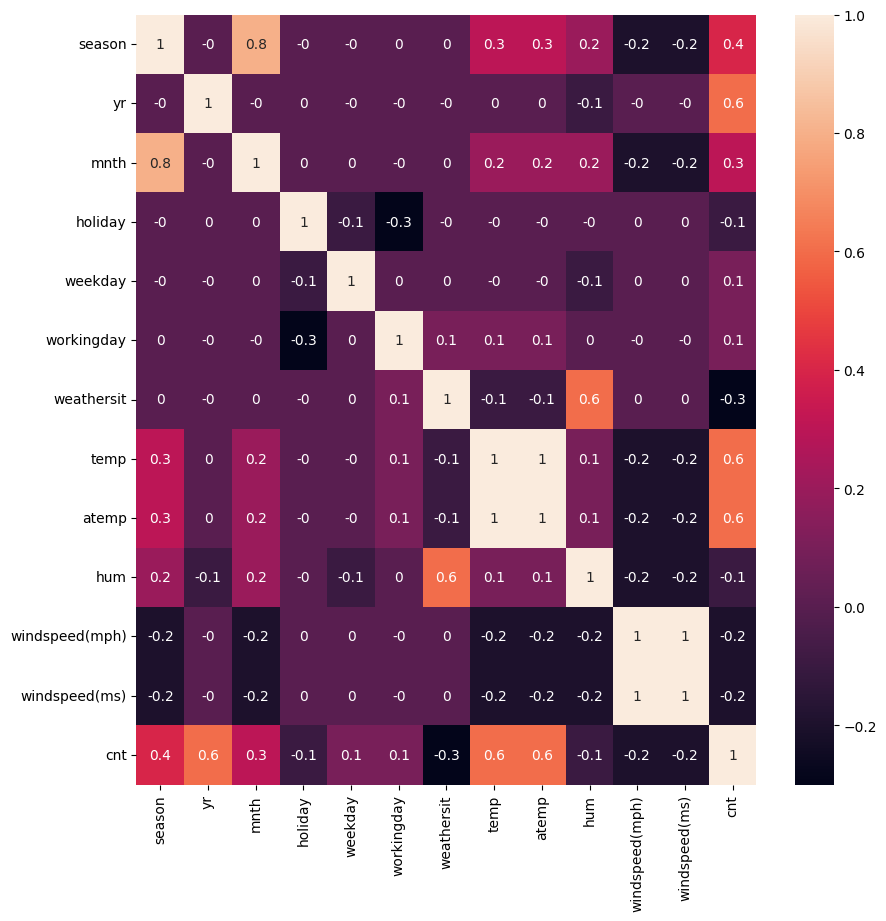

In [5]:
#etude de la correlation (arrondi à une décimale)
matrice_corr = bikes_df_norm.corr().round(1)
fig, ax = plt.subplots(figsize=(10, 10)) #specify size of heatmap
sns.heatmap(data=matrice_corr, annot=True)

Entraîner un modèle avec la regression linéaire (rappel). Il servira de référence pour nos expériences de régularisation.

In [6]:
# Define the X (input) and y (target) features
X = bikes_df_norm.drop("cnt", axis=1)
y = bikes_df_norm["cnt"]

# Split into train (2/3) and test (1/3) sets
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=5)

# apprentissage du modèle
lreg_model=LinearRegression() 
lreg_model.fit(X_train, y_train)
print("Estimated coefficients :",lreg_model.coef_)
print("Independent term in the linear model :",lreg_model.intercept_)

Estimated coefficients : [ 1.54203807e-01  2.34002302e-01 -1.67928688e-02 -3.36480474e-02
  5.99623174e-02  9.60701375e-03 -1.22630800e-01 -1.04980046e-01
  6.23449044e-01 -1.57558310e-01  9.66547078e+09 -9.66547078e+09]
Independent term in the linear model : 0.20167113673369863


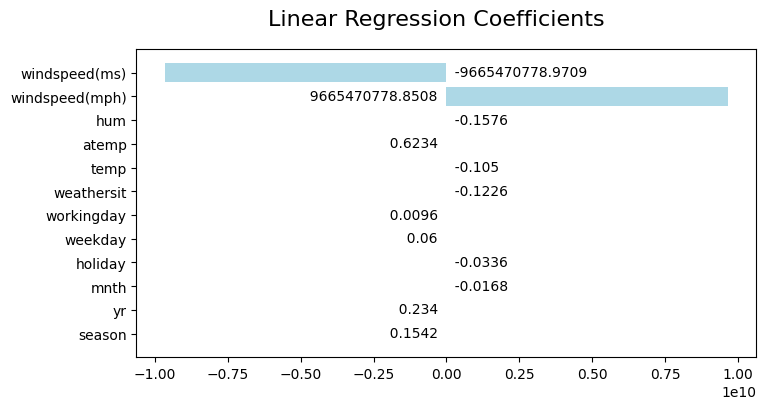

In [7]:
# Visualisation du modèle
tpiia_utils.linearRegressionSummary(lreg_model, X.columns)

Nous calculons la MSE (mean squared error) du modèle. 

In [8]:
y_pred=lreg_model.predict(X_test)
y_pred_train=lreg_model.predict(X_train)

baseline_error_test = mean_squared_error(y_pred,y_test)
baseline_error_train = mean_squared_error(y_pred_train,y_train)
print("Linear regression: MSE on test set: %.4f" % baseline_error_test)
print("Linear regression: MSE on train set: %.4f" % baseline_error_train)


Linear regression: MSE on test set: 0.0119
Linear regression: MSE on train set: 0.0092


## <font color="#1abc9c"> 2. Régularisation Ridge ($L_2$) et Lasso ($L_1$)</font>

### 2.1 Régularisation Ridge

Nous allons à présent entraîner un modèle de régression linéaire régularisé avec la régularisation Ridge. La régression Ridge est implémentée dans scikit-learn par la fonction <code> Ridge(alpha)</code>, où 'alpha' est le paramètre de régularisation (le $\lambda$ dans les équations).

In [9]:
#alpha: parametre de regularisation, souvent appele aussi lambda
lreg_ridge = Ridge(alpha=.003) 
lreg_ridge.fit(X_train,y_train)
print ("Ridge model:", (lreg_ridge.coef_))

Ridge model: [ 0.15095042  0.23362114 -0.01200632 -0.03363417  0.06026453  0.00977942
 -0.12371445 -0.09335775  0.61114732 -0.15734729 -0.07035554 -0.07035554]


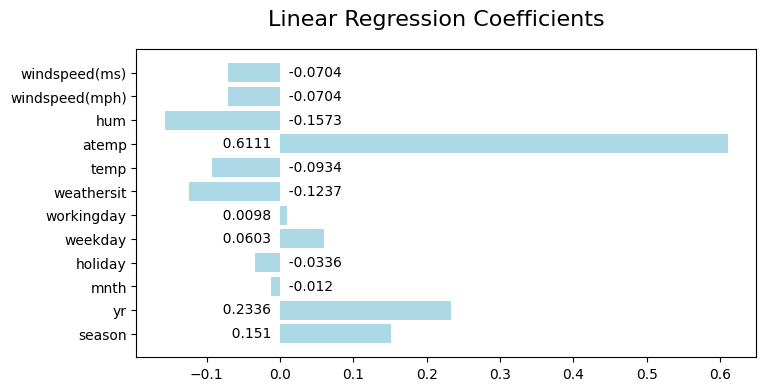

In [10]:
tpiia_utils.linearRegressionSummary(lreg_ridge, X.columns)

<font color="red">**Question 4 :**</font> Comparer les coefficients du modèle Ridge avec le modèle de régression linéaire standard. Globalement qu'observez-vous ?

<font color="red">**Question 5 :**</font> Observer les coefficients des attributs correlés. Quel semble être l'influence de la régression Ridge sur les coefficients des attributs corrélés ?

In [11]:
y_pred_ridge=lreg_ridge.predict(X_test)
y_pred_train_ridge=lreg_ridge.predict(X_train)

ridge_error_test = mean_squared_error(y_pred_ridge,y_test)
ridge_error_train = mean_squared_error(y_pred_train_ridge,y_train)
print("Ridge regression: MSE on test set: %.4f" % ridge_error_test)
print("Ridge regression: MSE on train set: %.4f" % ridge_error_train)


Ridge regression: MSE on test set: 0.0119
Ridge regression: MSE on train set: 0.0092


### 2.2 Régularisation Lasso

De la même façon, nous allons entraîner un modèle de régression linéaire régularisé avec la régularisation Lasso. 

In [12]:
lreg_lasso = Lasso(alpha=.003)
lreg_lasso.fit(X_train,y_train)
print ("Lasso model:", (lreg_lasso.coef_))

Lasso model: [ 1.34101434e-01  2.28682987e-01  0.00000000e+00 -0.00000000e+00
  3.45980591e-02  0.00000000e+00 -1.44358378e-01  2.41399043e-01
  1.97776352e-01 -0.00000000e+00 -2.39773745e-02 -2.02656522e-10]


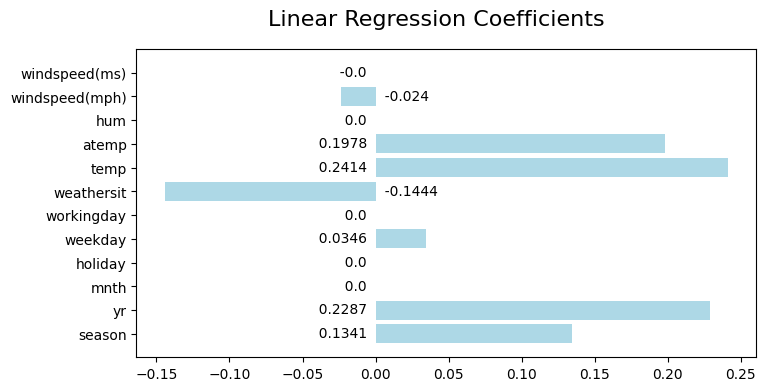

In [13]:
tpiia_utils.linearRegressionSummary(lreg_lasso, X.columns)

<font color="red">**Question 6 :**</font> Comparer les coefficients du modèle Lasso avec ceux du modèle Ridge (avec le même paramètre $\lambda$) et aussi avec ceux du modèle de régression linéaire. Qu'observez-vous ?



In [14]:
y_pred_lasso=lreg_lasso.predict(X_test)
y_pred_train_lasso=lreg_lasso.predict(X_train)

lasso_error_test = mean_squared_error(y_pred_lasso,y_test)
lasso_error_train = mean_squared_error(y_pred_train_lasso,y_train)
print("Lasso regression: MSE on test set: %.4f" % lasso_error_test)
print("Lasso regression: MSE on train set: %.4f" % lasso_error_train)

Lasso regression: MSE on test set: 0.0126
Lasso regression: MSE on train set: 0.0102


### 2.3 Influence du coefficient de régularisation

Dans ce qui suit, nous allons explorer les propriétés de la régularisation Ridge et Lasso.

Dans l'expérience suivante, nous entraînerons les modèles Ridge et Lasso avec différents paramètres de régularisation, et nous observerons comment les coefficients du modèle et les erreurs MSE changent. 

Nous allons tester 200 valeurs différentes de $\lambda$ comprises entre $10^{-5}$ et $10^5$.

In [15]:
# creation du vecteur contenant les 200 valeurs de alpha.
n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas)

# apprentissage d'un modele Ridge pour chaque valeur de alpha
# et calcul de l'erreur MSE
ridge = Ridge()
coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([baseline_error_test,  np.mean((ridge.predict(X_test) - y_test) ** 2) ])


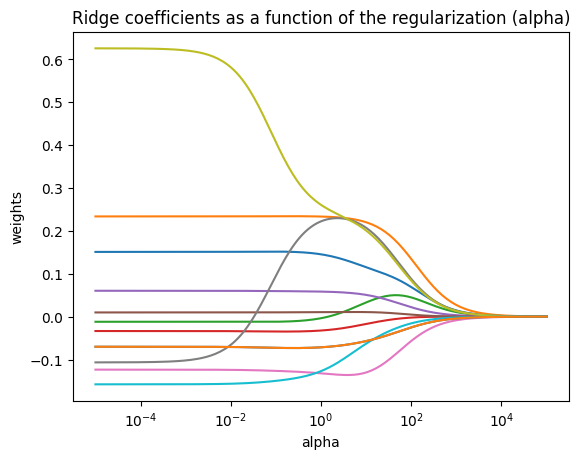

In [16]:
# visualisation des différents coefficients pour chaque attribut en fonction de alpha
tpiia_utils.plotCoeffEvolution('Ridge coefficients as a function of the regularization (alpha)',alphas, coefs)

<font color="red">**Question 7 :**</font> Que peut-on dire des coefficients si le paramètre de régularisation est égal à 0 ? Que peut-on dire des coefficients si le paramètre de régularisation a une valeur très élevée ?

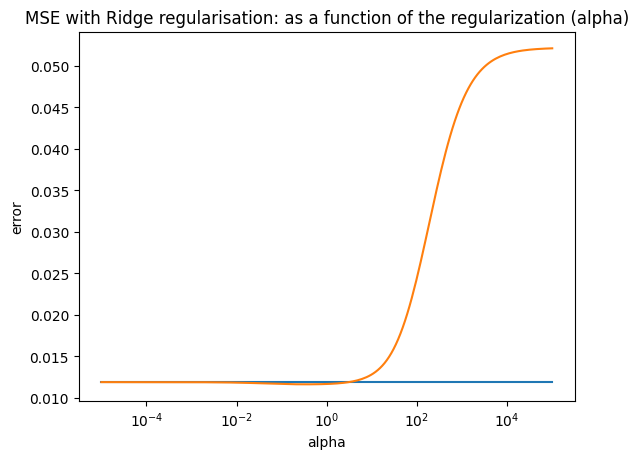

In [17]:
# visualisation de la MSE en fonction de alpha
tpiia_utils.plotErrorEvolution('MSE with Ridge regularisation: as a function of the regularization (alpha)',alphas, errors)

La courbe bleue correspond à la MSE de référence (régression linéaire non régularisée). La courbe orange à la MSE pour la régression Ridge.

<font color="red">**Question 8 :**</font> Que peut-on dire de l'erreur si le paramètre de régularisation est égal à 0 ? Que peut-on dire de l'erreur si le paramètre de régularisation a une valeur très élevée ? Quel est le problème dans ce cas ? (Rappeler le terme technique)

Nous allons maintenant faire une expérience similaire avec les modèles Lasso.  

In [18]:
# creation du vecteur contenant les 200 valeurs de alpha.
n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas)

# apprentissage d'un modele Lasso pour chaque valeur de alpha
# et calcul de l'erreur MSE
lasso=Lasso()
coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append([baseline_error_test, np.mean((lasso.predict(X_test) - y_test) ** 2)])

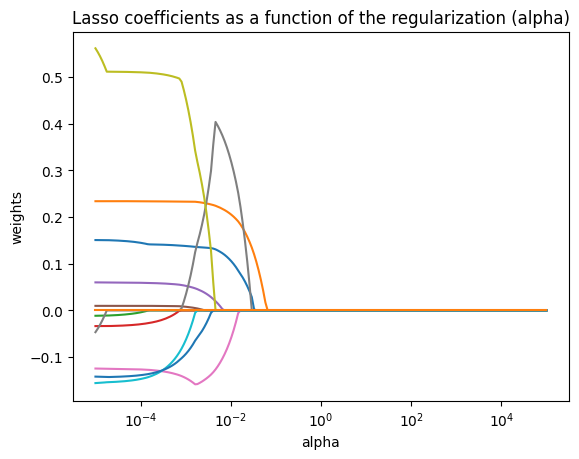

In [19]:
# visualisation des différents coefficients pour chaque attribut en fonction de alpha
tpiia_utils.plotCoeffEvolution('Lasso coefficients as a function of the regularization (alpha)',alphas, coefs)

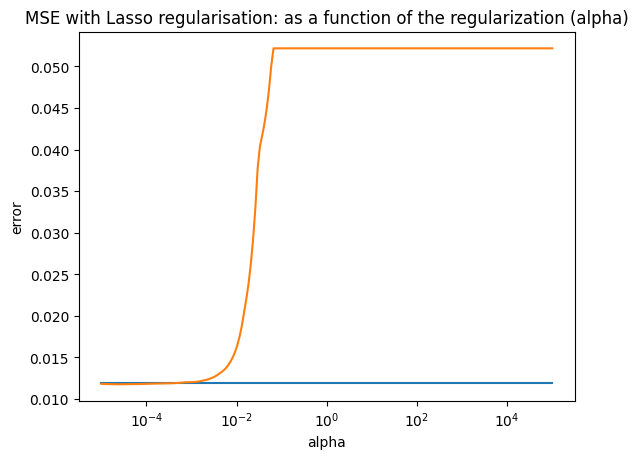

In [20]:
# visualisation de la MSE en fonction de alpha
tpiia_utils.plotErrorEvolution('MSE with Lasso regularisation: as a function of the regularization (alpha)',alphas, errors)

<font color="red">**Question 9:**</font> Comparer les graphes obtenus avec les graphes de la régularisation Ridge. 

<font color="red">**Question 10:**</font> A quel modèle correspond la MSE maximale qui est atteinte ? Quelle est son equation ?


## <font color="#1abc9c">3. Sélection de modèle</font>

Nous avons vu que différentes valeurs du paramètre de régularisation donnent des coefficients différents (donc des modèles différents) et que la qualité du modèle appris varie également. Le coefficient de régularisation $\lambda$ est un **hyper-paramètre** des modèles régularisés. Nous aimerions identifier pour quelle valeur de $\lambda$ nous obtenons le meilleur modèle. 

Tout comme dans le TP4 pour le degré de la transformation polynomiale, nous pouvons sélectionner les bons hyperparamètres par la méthode de validation croisée. Nous rappelons ici la méthodologie :

* Nous effectuons des expériences de validation croisée, sur l'ensemble d'entraînement. Cela nous permet de choisir les valeurs des hyper-paramètres. 

* Une fois que nous avons identifié les valeurs des hyper-paramètres, nous pouvons entraîner un modèle, avec ces valeurs, sur l'ensemble d'entraînement. 

* Nous évaluons le modèle appris sur l'ensemble de test. 


<code>LassoCV()</code> et <code>RidgeCV()</code> sont les méthodes de scikit-learn implémentant la recherche par validation croisée de la meilleure valeur de $\lambda$ pour les régressions Lasso et Ridge respectivement.  Elles retournent le meilleur modèle trouvé.

In [21]:
# Selection de modèle Lasso, avec validation croisée
# Si on ne precise pas les alphas, il va automatiquement identifier l'intervalle. 
# Aussi si on ne precise pas autrement, n_alphas = 100 

lasso_regCV = LassoCV(cv=5)
lasso_regCV.fit(X_train, y_train)

# Afficher la valeur retenue de alpha 
print('alpha: %f' % lasso_regCV.alpha_)

alpha: 0.000445


Vous pouvez trouver dans l'attribut <code>model.mse_path_</code> les résultats des expériences de validation croisée. 

<font color="red">**Question 11:**</font> 
- Expliquez la signification des chiffres que vous pouvez observer. 
- Quelle est la valeur min et max des valeurs de $\lambda$ testées ?

In [22]:
print("Dimension de 'alphas_': ",lasso_regCV.alphas_.shape)
print("Dimension de 'mse_path_': ",lasso_regCV.mse_path_.shape)
# affichage des premieres valeurs seulement pour lisibilité
print("Valeurs de alpha testées :", lasso_regCV.alphas_[0:10])
print("Detailed MSEs:", lasso_regCV.mse_path_[0:10,:])

Dimension de 'alphas_':  (100,)
Dimension de 'mse_path_':  (100, 5)
Valeurs de alpha testées : [0.06302551 0.05877781 0.05481638 0.05112194 0.04767649 0.04446325
 0.04146658 0.03867187 0.03606552 0.03363482]
Detailed MSEs: [[0.04278547 0.04611185 0.05910881 0.04489287 0.04864748]
 [0.04079811 0.04441884 0.05780876 0.04323445 0.04667477]
 [0.03892114 0.04245662 0.05569073 0.04181788 0.04496505]
 [0.03728654 0.0407399  0.05382961 0.04060991 0.04348366]
 [0.03586288 0.03923737 0.05219322 0.03958176 0.04220048]
 [0.03462282 0.03792178 0.05075348 0.03870848 0.04108934]
 [0.03354256 0.03676935 0.04948589 0.03796848 0.0401275 ]
 [0.03260142 0.03575941 0.04836906 0.03734311 0.0392952 ]
 [0.03178137 0.03487389 0.04738433 0.03681618 0.03857529]
 [0.03081045 0.03395928 0.04594318 0.03637374 0.03795286]]


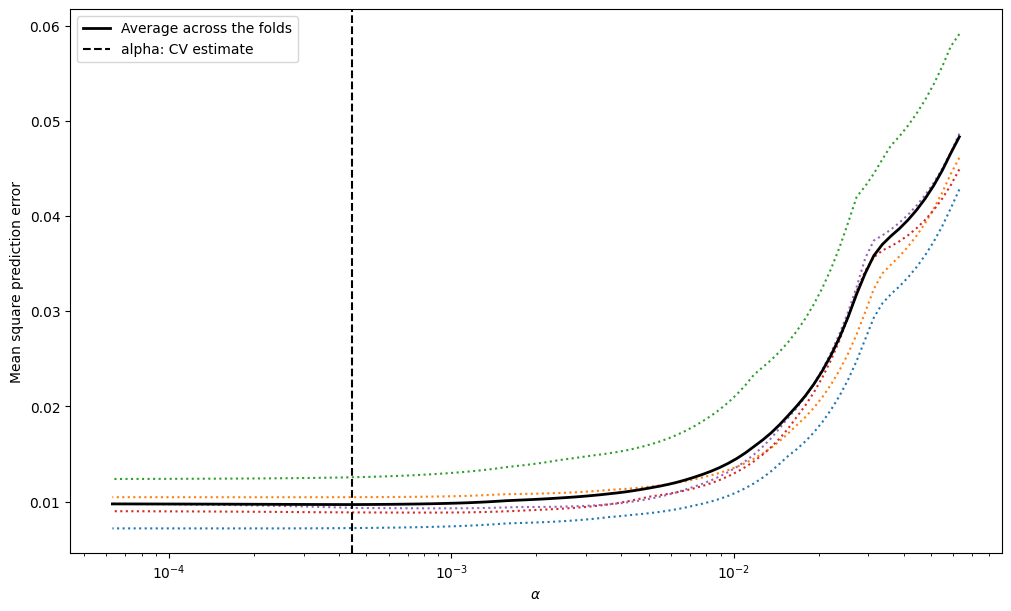

In [23]:
# Visualisation des résultats
tpiia_utils.plotLassoPredictionError(lasso_regCV)

<font color="red">**Question 12:**</font> Entrainez une régression Lasso, avec les hyper-parametres retenus. Évaluez le modèle. Quelle est l'erreur du modèle ? 

In [24]:
# TO DO : evaluation of the best Lasso model
lasso.set_params(alpha=lasso_regCV.alpha_)
lasso.fit(X_train, y_train)

y_pred_lasso=lasso.predict(X_test)
y_pred_train_lasso=lasso.predict(X_train)

lasso_error_test = mean_squared_error(y_pred_lasso,y_test)
lasso_error_train = mean_squared_error(y_pred_train_lasso,y_train)
print("Lasso regression: MSE on test set: %.4f" % lasso_error_test)
print("Lasso regression: MSE on train set: %.4f" % lasso_error_train)

Lasso regression: MSE on test set: 0.0119
Lasso regression: MSE on train set: 0.0092


In [25]:
# Selection de modèle Lasso, avec validation croisée
# Si on ne precise pas les alphas, il va automatiquement identifier l'intervalle. 
# Aussi si on ne precise pas autrement, n_alphas = 100 

ridge_regCV = RidgeCV(cv=5)
ridge_regCV.fit(X_train, y_train)

ridge.set_params(alpha=ridge_regCV.alpha_)
ridge.fit(X_train, y_train)

print(ridge_regCV.alpha_)

y_pred_ridge=ridge.predict(X_test)
y_pred_train_ridge=ridge.predict(X_train)

ridge_error_test = mean_squared_error(y_pred_ridge,y_test)
ridge_error_train = mean_squared_error(y_pred_train_ridge,y_train)
print("Ridge regression: MSE on test set: %.4f" % ridge_error_test)
print("Ridge regression: MSE on train set: %.4f" % ridge_error_train)



0.1
Ridge regression: MSE on test set: 0.0117
Ridge regression: MSE on train set: 0.0092


Vous pouvez réaliser la même procédure pour sélectionner le meilleur modèle avec une régularisation Ridge.

<font color="red">**Question 13:**</font> Quelle est la valeur de $\lambda$ sélectionnée par validation croisée ?  Quelle est l'erreur du meilleur modèle Ridge ?

<font color="red">**Question 14:**</font> Récapitulez dans un tableau les performances obtenues pour la régression linéaire et les régressions Ridge et Lasso (en indiquant la valeur de paramètre $\lambda$).

In [26]:
# Ridge regression evaluation with alpha selected by cross-validation.
# Pour la regularisation Ridge les valeurs de alphas testées par défaut sont (0.1, 1.0, 10.0)

ridge_regCV = RidgeCV(cv=5)
ridge_regCV.fit(X_train, y_train)

print('best alpha: %f' % ridge_regCV.alpha_)
print('best score (r2 score): %f' % ridge_regCV.best_score_)

# TO COMPLETE : evaluation du meilleur modele


best alpha: 0.100000
best score (r2 score): 0.797015



## <font color="#1abc9c">4. Régularisation pour éviter le sur-apprentissage (overfitting)</font>

Dans ce qui suit, vous observerez comment la régularisation peut empêcher l'overfitting (variance élevée). Nous travaillerons avec le jeu de données sur les logements de Boston (voir TP4). Vous avez observé qu'une expansion polynomiale avec un degré élevé conduit à un sur-apprentissage (par exemple, n=9). Il est clair que si l'on réduit le degré du polynôme, on peut éviter l'overfitting. Nous aimerions apprendre maintenant un modèle avec une expansion polynomiale de degré 9, et éviter l'overfitting par régularisation. Vous pouvez également observer que trop de régularisation conduit à un under-fitting (biais élevé). 


In [27]:
# Load Boston housing data set
boston_df = pd.read_csv("./data/boston.csv")

print("\n Statistiques")
boston_df.describe()


 Statistiques


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


Comme dans le cas précédent, les attributs ont des ordres de grandeur différents.

In [28]:
scaler = MinMaxScaler()
boston_df_norm =pd.DataFrame(scaler.fit_transform(boston_df.values),columns=boston_df.columns, index=boston_df.index )
boston_df_norm.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,0.040544,0.113636,0.391378,0.069170,0.349167,0.521869,0.676364,0.242381,0.371713,0.422208,0.622929,0.301409,0.389618
std,0.096679,0.233225,0.251479,0.253994,0.238431,0.134627,0.289896,0.191482,0.378576,0.321636,0.230313,0.197049,0.204380
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000851,0.000000,0.173387,0.000000,0.131687,0.445392,0.433831,0.088259,0.130435,0.175573,0.510638,0.144040,0.267222
50%,0.002812,0.000000,0.338343,0.000000,0.314815,0.507281,0.768280,0.188949,0.173913,0.272901,0.686170,0.265728,0.360000
75%,0.041258,0.125000,0.646628,0.000000,0.491770,0.586798,0.938980,0.369088,1.000000,0.914122,0.808511,0.420116,0.444444
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Entraînons un modèle de régression linéaire univarié.  

In [29]:
# Define the X (input) and y (target) features
X = boston_df_norm[["LSTAT"]]
y = boston_df_norm["MEDV"]

# Split into train (2/3) and test (1/3) sets
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=4)

# apprentissage du modèle
lreg_model=LinearRegression()
lreg_model.fit(X_train, y_train)
print("Estimated coefficients :",lreg_model.coef_)
print("Independent term in the linear model :",lreg_model.intercept_)

Estimated coefficients : [-0.70563969]
Independent term in the linear model : 0.5919326884701027


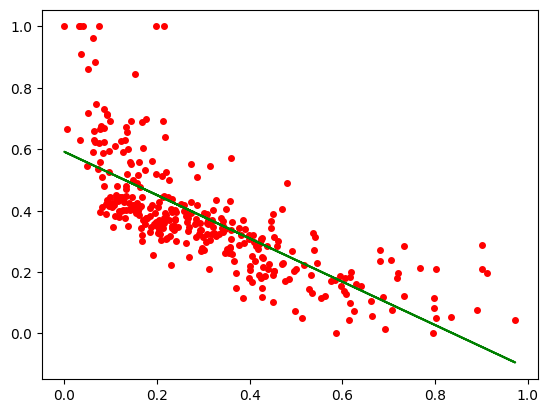

In [30]:
# Visualisation du modèle appris
plt.plot(X_train, y_train, 'ro', markersize=4)
plt.plot(X_train, lreg_model.predict(X_train),color='g')

Entraînons maintenant un modèle linéaire sur l'expansion polynomiale (degré 9). 

In [31]:
X_train_p9 = PolynomialFeatures(degree=9,include_bias=False).fit_transform(X_train)
X_test_p9 =  PolynomialFeatures(degree=9,include_bias=False).fit_transform(X_test)

# apprentissage du modèle
lreg_model_poly=LinearRegression()
lreg_model_poly.fit(X_train_p9, y_train)
print("Estimated coefficients :",lreg_model_poly.coef_)
print("Independent term in the linear model :",lreg_model_poly.intercept_)

Estimated coefficients : [-2.70275394e+00 -6.41256570e+01  8.34883442e+02 -4.35157728e+03
  1.22423063e+04 -2.00874996e+04  1.92257726e+04 -9.94556193e+03
  2.14754906e+03]
Independent term in the linear model : 0.9532859762323642


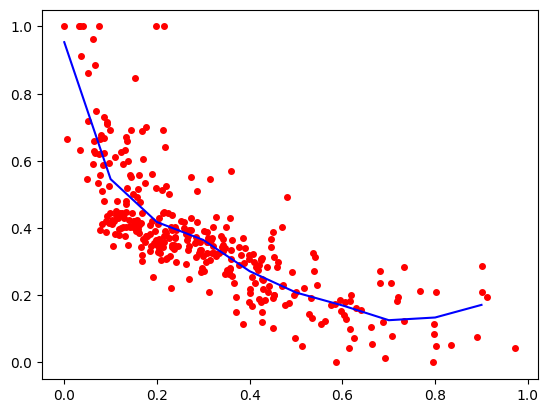

In [32]:
# visualisation du modèle appris
tpiia_utils.plot_regression_model_pf(lreg_model_poly, PolynomialFeatures(degree=9,include_bias=False), X_train, y_train)

<font color="red">**Task:**</font> 
- Entraînez un modèle régularisé (Ridge) avec le paramètre 0.1 et visualisez le modèle. 
- Observez le comportement du modèle, pour différentes valeurs de paramètre (par exemple 0.001, 1, 10)
- Evaluez le modèle pour chaque valeur de paramètre. 

<font color="red">**Question 15:**</font> Reportez dans un tableau les erreurs réelles et empiriques, pour chaque valeur de paramètre de régularisation. Expiquez vos observations. 


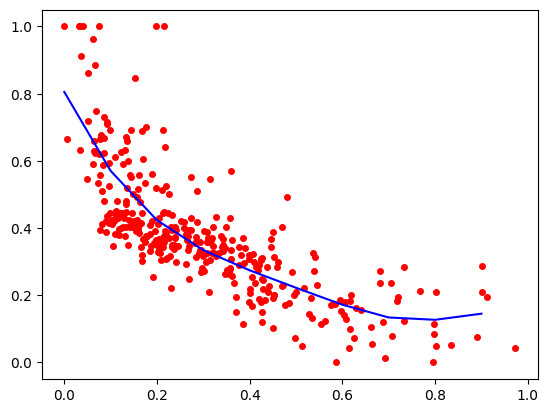

Ridge regression: MSE on test set: 0.0179
Ridge regression: MSE on train set: 0.0122


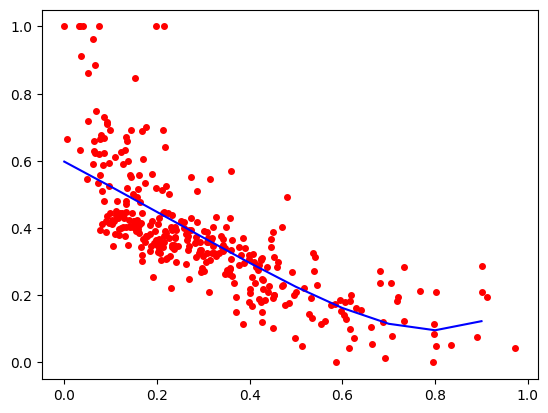

Ridge regression: MSE on test set: 0.0253
Ridge regression: MSE on train set: 0.0143


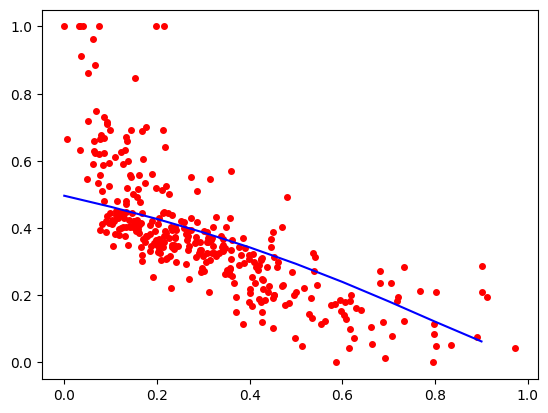

Ridge regression: MSE on test set: 0.0348
Ridge regression: MSE on train set: 0.0188


In [33]:
# TO MODIFY
for a in (0.001, 1, 10):
    lreg_ridge = Ridge(alpha=a)
    lreg_ridge.fit(X_train_p9,y_train)
    tpiia_utils.plot_regression_model_pf(lreg_ridge, PolynomialFeatures(degree=9,include_bias=False), X_train, y_train)

    y_pred_lasso=lreg_ridge.predict(X_test_p9)
    y_pred_train_lasso=lreg_ridge.predict(X_train_p9)
    
    etest = mean_squared_error(y_pred_lasso,y_test)
    etrain = mean_squared_error(y_pred_train_lasso,y_train)
    print("Ridge regression: MSE on test set: %.4f" % etest)
    print("Ridge regression: MSE on train set: %.4f" % etrain)


In [34]:
# TO COMPLETE : evaluation du modele


###  Sélection de modèle par validation croisée

Nous présentons comment déterminer le paramètre de régularisation par validation croisée, en utilisant <code> GridSearchCV </code> (cf. TP4). 

In [35]:
# Pour utiliser GridSearchCV, nous avons besoin d'un modèle dont nous pouvons modifier les hyperparamètres 
# (ici regression regularisee). 
# On construit un pipeline qui est une combinaison de l'expansion polynomiale et de la regression logistique.
 
estimator = make_pipeline(PolynomialFeatures(degree=9,include_bias=False), Ridge())

hyperparams = {'ridge__alpha':[0,0.001,0.01,0.1,1,10]}

# GridSearch va evaluer le score des modeles, pour les differentes valeurs des hyperparametres, 
# et avec une validation croisé (ici, 10 plis)
ridge_regCV = GridSearchCV(estimator, hyperparams, cv = 10, scoring='neg_root_mean_squared_error', verbose=2, return_train_score=True)
ridge_regCV.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END .....................................ridge__alpha=0; total time=   0.0s
[CV] END .....................................ridge__alpha=0; total time=   0.0s
[CV] END .....................................ridge__alpha=0; total time=   0.0s
[CV] END .....................................ridge__alpha=0; total time=   0.0s
[CV] END .....................................ridge__alpha=0; total time=   0.0s
[CV] END .....................................ridge__alpha=0; total time=   0.0s
[CV] END .....................................ridge__alpha=0; total time=   0.0s
[CV] END .....................................ridge__alpha=0; total time=   0.0s
[CV] END .....................................ridge__alpha=0; total time=   0.0s
[CV] END .....................................ridge__alpha=0; total time=   0.0s
[CV] END .................................ridge__alpha=0.001; total time=   0.0s
[CV] END .................................ridge_

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=9,
                                                           include_bias=False)),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0, 0.001, 0.01, 0.1, 1, 10]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=2)

In [36]:
#afficher le meilleur param et meilleur score
print(ridge_regCV.best_estimator_)
print(ridge_regCV.best_params_)
print(ridge_regCV.best_score_)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=9, include_bias=False)),
                ('ridge', Ridge(alpha=0.001))])
{'ridge__alpha': 0.001}
-0.1116219731568634


<font color="red">**Question 16:**</font> 
- Quelle est la valeur de $\lambda$ retenue par validation croisée ? 
- Quelle est la performance du modèle retenu ?

In [38]:
# TO COMPLETE - evaluation du meilleur modele ridge sur ensemble de test

ridge_regCV = Ridge(alpha=0.001)
ridge_regCV.fit(X_train,y_train)
#tpiia_utils.plot_regression_model_pf(ridge_regCV, PolynomialFeatures(degree=9,include_bias=False), X_train, y_train)


y_pred=ridge_regCV.predict(X_test)
y_pred_train=ridge_regCV.predict(X_train)

etest = mean_squared_error(y_pred,y_test)
etrain = mean_squared_error(y_pred_train,y_train)
print("Ridge regression: MSE on test set: %.4f" % etest)
print("Ridge regression: MSE on train set: %.4f" % etrain)

Ridge regression: MSE on test set: 0.0269
Ridge regression: MSE on train set: 0.0155
